In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from datetime import datetime
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
from TweetProcessor import TweetProcessor as tp
tweet_processor = tp.TweetProcessor()
start_all = datetime.now()

# Comparison of various sentiment analysis frameworks

I explore the performance of **VADER** and **TextBlob** against my **TweetProcessor** framework. The sentiment score of is calculated using raw or preprocessed tweets from the [Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/) dataset of kaggle. The tokenization is applied through the `tweet_preprocessing` function of **TweetProcessor**. Additionally the **TextBlob Naive Bayes** classifier is tested against my **one-vs-rest Bernoulli Naive Bayes** classifier.

The evaluation is concluded by visualizing the confusion matrix of the prediction as well as the prediction distribution and presenting the classicification metrics (accuracy, precision, recall, f1-score)

1. VADER sentiment with raw tweets
2. VADER sentiment with tokenized tweets
3. TextBlob sentiment with raw tweets
4. TextBlob sentiment with tokenized tweets
5. TextBlob Naive Bayes classifier
6. TweetProcessor one-vs-rest Bernoulli Naive Bayes classifier

#### Helper functions

In [3]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


def evaluate_model(y_test, y_pred):
   accuracy = np.around(metrics.accuracy_score(y_test, y_pred),3)
   precision = np.around(metrics.precision_score(y_test, y_pred, average='macro'),3)
   recall = np.around(metrics.recall_score(y_test, y_pred, average='macro'),3)
   f1_score = np.around(metrics.f1_score(y_test, y_pred, average='macro'),3)
   print(classification_report(y_test, y_pred))  
   print('accuracy: %s' % accuracy)
   print('precision: %s' % precision)
   print('recall: %s' % recall)
   print('f1_score: %s' % f1_score)
   return {'accuracy':accuracy, 
           'precision':precision, 
           'recall':recall,
           'f1_score':f1_score}

def vader_sentiment(doc):
   analyzer= SentimentIntensityAnalyzer()
   score = analyzer.polarity_scores(doc)['compound']
   if score == 0:
      return 'neutral'
   elif score < 0:
      return 'negative'
   else:
      return 'positive'
   
def textblob_sentiment(doc):
   from textblob import TextBlob
   score = TextBlob(doc).sentiment.polarity
   if score == 0:
      return 'neutral'
   elif score < 0:
      return 'negative'
   else:
      return 'positive'
   
def plot_confusion_matrix(y_test, y_pred):
   from sklearn.preprocessing import MinMaxScaler
   from sklearn.metrics import classification_report, confusion_matrix
   
   labels = np.unique(y_test)
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print(cm_df)
   cmap = sns.color_palette("OrRd", 1000)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g')
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   
def vizualize_classification(y_test, y_pred):
   from sklearn.metrics import classification_report, confusion_matrix
   labels = np.unique(y_test)
   cmap = sns.color_palette("OrRd", 1000)
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
   fig.suptitle('Vizualizing classifier')
   
   ax = sns.countplot(x=y_pred, hue=y_test, order=labels, ax=ax1)
   
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print('Confusion Matrix: \n', cm_df)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g', ax=ax2)
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   evaluate_model(y_test, y_pred)
   
def textblob_NBClassifier(doc):
   blob = TextBlob(doc, classifier=cl)
   return blob.classify()

In [27]:
airline_df = pd.read_csv('TwitterAirlineSentiment.csv')
airline_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Feature selection

In [7]:
x_indices = range(airline_df.shape[0])
y = airline_df['airline_sentiment'].values
x_train_indices, x_test_indices, y_train, y_test = train_test_split(x_indices, y, test_size=0.2, random_state=0)

airline_df['tokenized_features'] = airline_df['text'].apply(tweet_processor.tweet_pipeline)
train_df = airline_df.loc[x_train_indices, ('tokenized_features', 'airline_sentiment', 'text')]
test_df = airline_df.loc[x_test_indices, ('tokenized_features', 'airline_sentiment', 'text')]

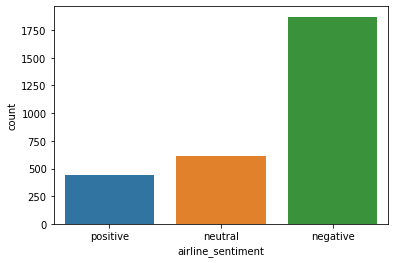

In [8]:
# Groundtruth destribution
ax = sns.countplot(x="airline_sentiment", data=test_df, order=['positive', 'neutral', 'negative'])

## VADER

In [9]:
test_df['vader_sentiment'] = test_df['text'].apply(vader_sentiment)

## VADER
### Raw VADER

Confusion Matrix: 
           negative  neutral  positive
negative       814      262       794
neutral         59      191       364
positive        13       32       399
              precision    recall  f1-score   support

    negative       0.92      0.44      0.59      1870
     neutral       0.39      0.31      0.35       614
    positive       0.26      0.90      0.40       444

    accuracy                           0.48      2928
   macro avg       0.52      0.55      0.45      2928
weighted avg       0.71      0.48      0.51      2928

accuracy: 0.48
precision: 0.523
recall: 0.548
f1_score: 0.446


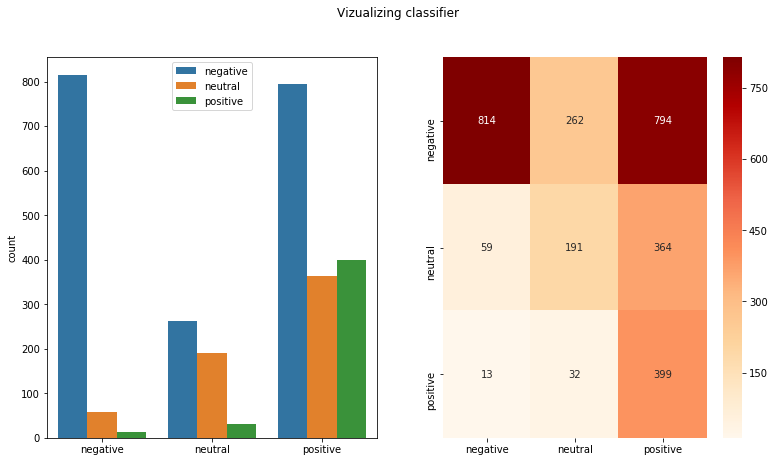

In [11]:
vizualize_classification(test_df['airline_sentiment'].values,  test_df['vader_sentiment'].values)

### Tokenized VADER

In [12]:
test_df['tokenized_vader_sentiment'] = test_df['tokenized_features'].apply(lambda x: vader_sentiment(' '.join(x)))

Confusion Matrix: 
           negative  neutral  positive
negative       900      311       659
neutral         79      240       295
positive        21       41       382
              precision    recall  f1-score   support

    negative       0.90      0.48      0.63      1870
     neutral       0.41      0.39      0.40       614
    positive       0.29      0.86      0.43       444

    accuracy                           0.52      2928
   macro avg       0.53      0.58      0.48      2928
weighted avg       0.70      0.52      0.55      2928

accuracy: 0.52
precision: 0.53
recall: 0.578
f1_score: 0.485


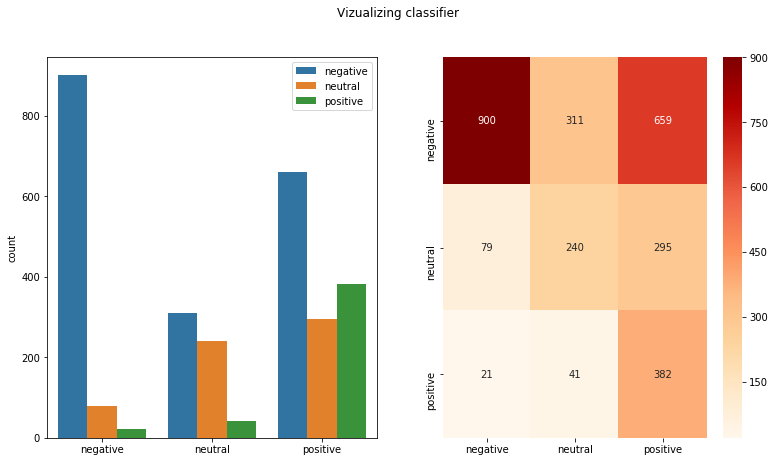

In [13]:
vizualize_classification(test_df['airline_sentiment'].values,  test_df['tokenized_vader_sentiment'].values)

## TextBlob
### Raw TextBlob

In [14]:
test_df['textblob_sentiment'] = test_df['text'].apply(textblob_sentiment)

Confusion Matrix: 
           negative  neutral  positive
negative       631      704       535
neutral         59      356       199
positive        17       88       339
              precision    recall  f1-score   support

    negative       0.89      0.34      0.49      1870
     neutral       0.31      0.58      0.40       614
    positive       0.32      0.76      0.45       444

    accuracy                           0.45      2928
   macro avg       0.51      0.56      0.45      2928
weighted avg       0.68      0.45      0.47      2928

accuracy: 0.453
precision: 0.506
recall: 0.56
f1_score: 0.447


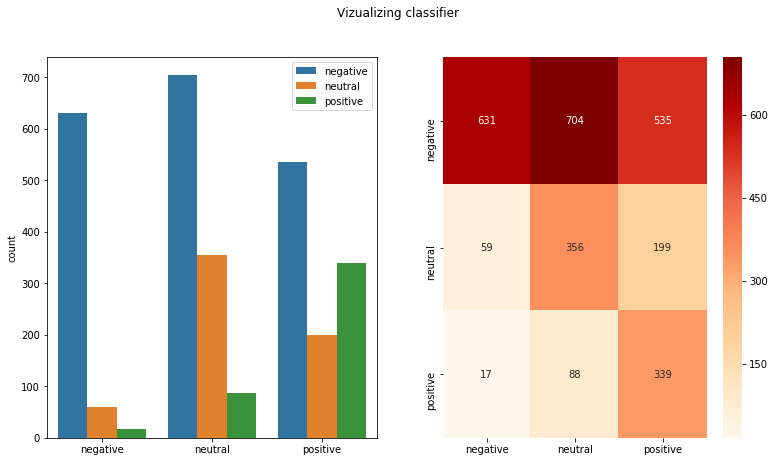

In [15]:
vizualize_classification(test_df['airline_sentiment'].values,  test_df['textblob_sentiment'].values)

### Tokenized TextBlob

In [16]:
test_df['tokenized_textblob_sentiment'] = test_df['tokenized_features'].apply(lambda x: textblob_sentiment(' '.join(x)))

Confusion Matrix: 
           negative  neutral  positive
negative       622      715       533
neutral         58      356       200
positive        18       90       336
              precision    recall  f1-score   support

    negative       0.89      0.33      0.48      1870
     neutral       0.31      0.58      0.40       614
    positive       0.31      0.76      0.44       444

    accuracy                           0.45      2928
   macro avg       0.50      0.56      0.44      2928
weighted avg       0.68      0.45      0.46      2928

accuracy: 0.449
precision: 0.504
recall: 0.556
f1_score: 0.443


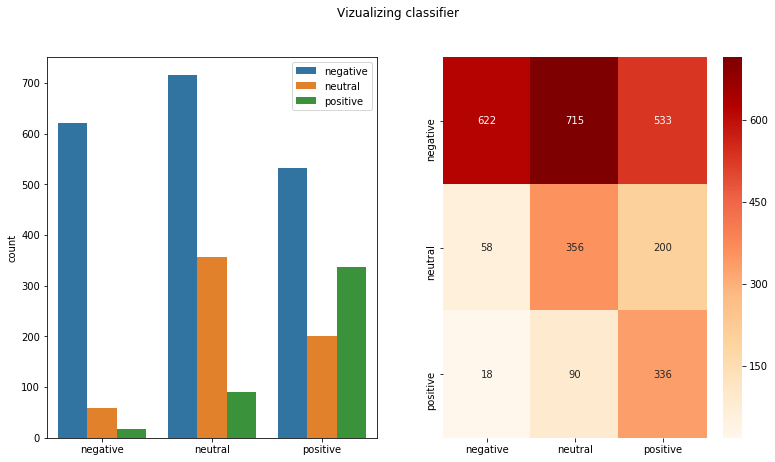

In [17]:
vizualize_classification(test_df['airline_sentiment'].values,  test_df['tokenized_textblob_sentiment'].values)

### TextBlob classifier raw

In [18]:
from textblob.classifiers import NaiveBayesClassifier
start = datetime.now()

x_train = train_df['text'].apply(lambda x: ' '.join(x)).values
x_test = test_df['text'].apply(lambda x: ' '.join(x)).values
train = list(zip(x_train, y_train))
cl = NaiveBayesClassifier(train)

print('Finished training in : ', datetime.now()-start)


Finished training in :  0:00:10.106139


In [19]:
start = datetime.now()

test_df['textblob_NB_sentiment'] = test_df['text'].apply(lambda x: textblob_NBClassifier(' '.join(x)))
print('Finished classification in : ', datetime.now()-start)

Finished classification in :  0:00:04.545445


Confusion Matrix: 
           negative  neutral  positive
negative      1582      147       141
neutral        355      166        93
positive       242       62       140
              precision    recall  f1-score   support

    negative       0.73      0.85      0.78      1870
     neutral       0.44      0.27      0.34       614
    positive       0.37      0.32      0.34       444

    accuracy                           0.64      2928
   macro avg       0.51      0.48      0.49      2928
weighted avg       0.61      0.64      0.62      2928

accuracy: 0.645
precision: 0.514
recall: 0.477
f1_score: 0.486


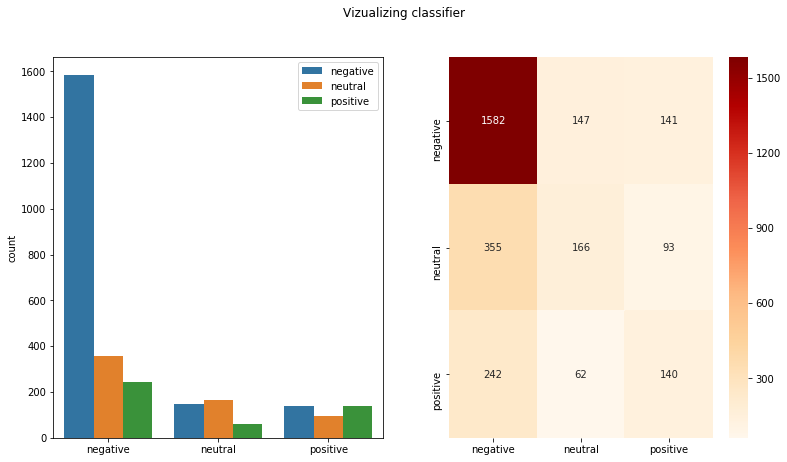

In [20]:
vizualize_classification(test_df['airline_sentiment'].values,  test_df['textblob_NB_sentiment'].values)

### TextBlob classifier tokenized

In [21]:
from textblob.classifiers import NaiveBayesClassifier
start = datetime.now()

x_train = train_df['tokenized_features'].apply(lambda x: ' '.join(x)).values
x_test = test_df['tokenized_features'].apply(lambda x: ' '.join(x)).values
train = list(zip(x_train, y_train))
cl = NaiveBayesClassifier(list(zip(x_train, y_train)))
print('Finished training in : ', datetime.now()-start)

Finished training in :  0:02:04.608798


In [22]:
start = datetime.now()
test_df['textblob_NB_tokenized_sentiment'] = test_df['tokenized_features'].apply(lambda x: textblob_NBClassifier(' '.join(x)))
print('Finished classification in : ', datetime.now()-start)

Finished classification in :  0:16:59.054525


Confusion Matrix: 
           negative  neutral  positive
negative      1705      129        36
neutral        245      327        42
positive       114       58       272
              precision    recall  f1-score   support

    negative       0.83      0.91      0.87      1870
     neutral       0.64      0.53      0.58       614
    positive       0.78      0.61      0.69       444

    accuracy                           0.79      2928
   macro avg       0.75      0.69      0.71      2928
weighted avg       0.78      0.79      0.78      2928

accuracy: 0.787
precision: 0.746
recall: 0.686
f1_score: 0.711


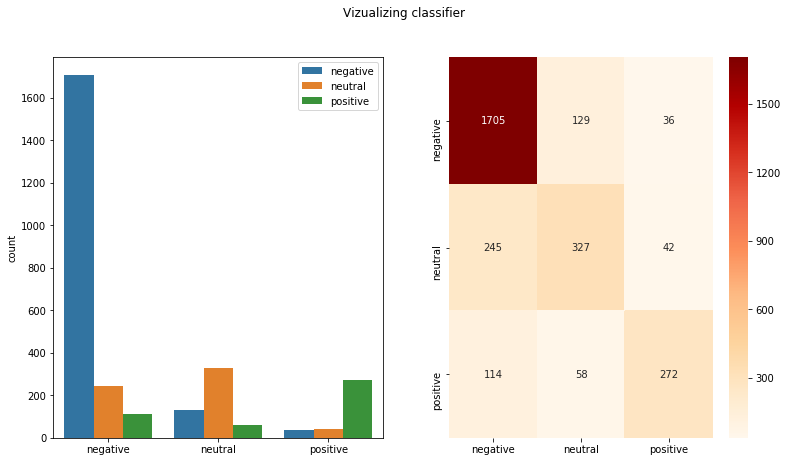

In [23]:
vizualize_classification(test_df['airline_sentiment'].values,  test_df['textblob_NB_tokenized_sentiment'].values)

## TweetProcessor with BernoulliNB classifier

In [24]:
X = airline_df['tokenized_features'].apply(lambda x: ' '.join(x)).values

vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)

x_combined = np.hstack((X_tfidf.toarray(),X_emoji.toarray()))

x_train, x_test = x_combined[x_train_indices], x_combined[x_test_indices]

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

print("")
print("Starting OneVsRestClassifier BernoulliNB classifier...")
print("")
start = datetime.now()
pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB()))
            ])

parameters = [{
            'clf__estimator__alpha': (0.001, 0.01, 0.4, 0.6, 0.8, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, parameters, cv=2)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

y_pred = best_clf.predict(x_test)
predict_proba = best_clf.predict_proba(x_test)

print('Finished training in : ', datetime.now()-start)
print(best_clf.get_params())


Starting OneVsRestClassifier BernoulliNB classifier...

Finished training in :  0:01:24.071787
{'memory': None, 'steps': [('clf', OneVsRestClassifier(estimator=BernoulliNB(alpha=0.8, binarize=0.0,
                                          class_prior=None, fit_prior=True),
                    n_jobs=None))], 'verbose': False, 'clf': OneVsRestClassifier(estimator=BernoulliNB(alpha=0.8, binarize=0.0,
                                          class_prior=None, fit_prior=True),
                    n_jobs=None), 'clf__estimator__alpha': 0.8, 'clf__estimator__binarize': 0.0, 'clf__estimator__class_prior': None, 'clf__estimator__fit_prior': True, 'clf__estimator': BernoulliNB(alpha=0.8, binarize=0.0, class_prior=None, fit_prior=True), 'clf__n_jobs': None}


Confusion Matrix: 
           negative  neutral  positive
negative      1592      202        76
neutral        167      387        60
positive        59       66       319
              precision    recall  f1-score   support

    negative       0.88      0.85      0.86      1870
     neutral       0.59      0.63      0.61       614
    positive       0.70      0.72      0.71       444

    accuracy                           0.78      2928
   macro avg       0.72      0.73      0.73      2928
weighted avg       0.79      0.78      0.79      2928

accuracy: 0.785
precision: 0.723
recall: 0.733
f1_score: 0.728


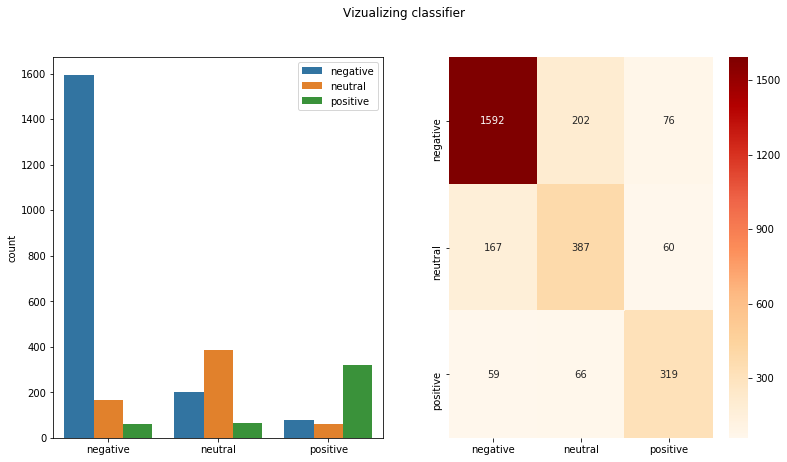

In [25]:
vizualize_classification(y_test, y_pred)

In [26]:
print('Finished training in : ', datetime.now()-start_all)

Finished training in :  0:23:04.225445
